Vendor's risk analysis

Importing Related Libraries

In [360]:
pip install fastapi uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [292]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
from pandas.core.series import Series
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier ,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix


Store the dataset into the Dataframe

In [295]:
df = pd.read_csv('Invoices_Train.csv')

vendorsDF = pd.read_csv('Vendors.csv')

In [297]:
# Merge invoice data with vendor details
df = df.merge(vendorsDF, on="Vendor_ID", how="left")

In [299]:
df.head()

,Invoice_ID,Vendor_ID,Invoice_Date,Total_Amount,Currency,Status,Exchange_Rate,Total_Amount_INR,Vendor_Name,Country,Category
0,INV-00001,VEND-019,2023-01-01,929.46,USD,Paid,82.5,76680.450,Vendor_19,UK,IT Services
1,INV-00002,VEND-008,2023-01-02,621.19,USD,Paid,82.5,51248.175,Vendor_8,Canada,Office Equipment
2,INV-00003,VEND-016,2023-01-03,3375.33,USD,Paid,82.5,278464.725,Vendor_16,UK,Consulting
3,INV-00004,VEND-002,2023-01-04,4188.03,GBP,Paid,102.0,427179.060,Vendor_2,USA,Consulting
4,INV-00005,VEND-004,2023-01-05,3504.20,GBP,Pending,102.0,357428.400,Vendor_4,UK,Stationery


In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Invoice_ID        5000 non-null   object 
 1   Vendor_ID         5000 non-null   object 
 2   Invoice_Date      5000 non-null   object 
 3   Total_Amount      5000 non-null   float64
 4   Currency          5000 non-null   object 
 5   Status            5000 non-null   object 
 6   Exchange_Rate     5000 non-null   float64
 7   Total_Amount_INR  5000 non-null   float64
 8   Vendor_Name       5000 non-null   object 
 9   Country           5000 non-null   object 
 10  Category          5000 non-null   object 
dtypes: float64(3), object(8)
memory usage: 429.8+ KB


In [303]:

# Convert Invoice_Date to datetime
df["Invoice_Date"] = pd.to_datetime(df["Invoice_Date"])

In [305]:
# Summary statistics
print(df.describe())

              Invoice_Date  Total_Amount  Exchange_Rate  Total_Amount_INR
count                 5000   5000.000000    5000.000000       5000.000000
mean   2029-11-04 12:00:00   2767.295120      85.761700     237350.840717
min    2023-01-01 00:00:00    500.380000      82.500000      41466.975000
25%    2026-06-03 18:00:00   1636.087500      82.500000     139116.881250
50%    2029-11-04 12:00:00   2745.420000      82.500000     233848.160000
75%    2033-04-07 06:00:00   3943.752500      89.000000     336277.972500
max    2036-09-08 00:00:00   4999.580000     102.000000     509342.100000
std                    NaN   1313.244573       5.886577     114035.549996


Data Cleaning

In [308]:

# Check for missing values
print(df.isnull().sum())

Invoice_ID          0
Vendor_ID           0
Invoice_Date        0
Total_Amount        0
Currency            0
Status              0
Exchange_Rate       0
Total_Amount_INR    0
Vendor_Name         0
Country             0
Category            0
dtype: int64


columns total_amount,curruncy,exchange_rate is not in use for our prediction,removing such columns.

In [311]:
drop_cols=['Total_Amount',"Exchange_Rate","Currency"]
df=df.drop(columns=drop_cols)
df.head()

,Invoice_ID,Vendor_ID,Invoice_Date,Status,Total_Amount_INR,Vendor_Name,Country,Category
0,INV-00001,VEND-019,2023-01-01,Paid,76680.450,Vendor_19,UK,IT Services
1,INV-00002,VEND-008,2023-01-02,Paid,51248.175,Vendor_8,Canada,Office Equipment
2,INV-00003,VEND-016,2023-01-03,Paid,278464.725,Vendor_16,UK,Consulting
3,INV-00004,VEND-002,2023-01-04,Paid,427179.060,Vendor_2,USA,Consulting
4,INV-00005,VEND-004,2023-01-05,Pending,357428.400,Vendor_4,UK,Stationery


check for duplicates

In [314]:
(df.duplicated()==True).sum()

0

Understanding Target Variable (Invoice Payment Status):

Count of Paid vs. Pending Invoices

/var/folders/b5/7xxf201d4dlgs0txsxw00m8w0000gn/T/ipykernel_14998/1796526284.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Status", palette="coolwarm")


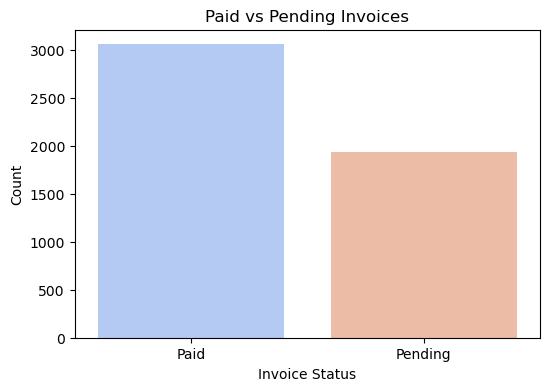

In [317]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Status", palette="coolwarm")
plt.xlabel("Invoice Status")
plt.ylabel("Count")
plt.title("Paid vs Pending Invoices")
plt.show()

Vendor-wise Analysis

1) Top Vendors with Most Invoices

/var/folders/b5/7xxf201d4dlgs0txsxw00m8w0000gn/T/ipykernel_14998/1105936036.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_vendors.index, x=top_vendors.values, palette="Blues_r")


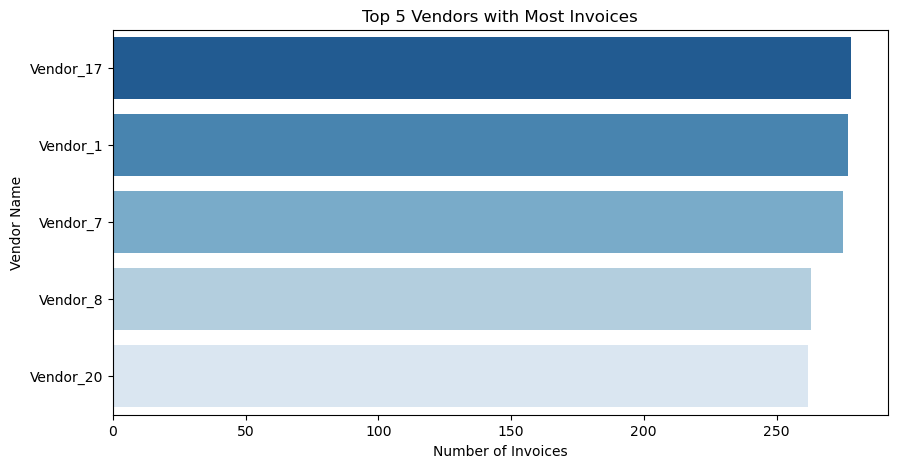

In [320]:
top_vendors = df["Vendor_Name"].value_counts().head(5)

plt.figure(figsize=(10,5))
sns.barplot(y=top_vendors.index, x=top_vendors.values, palette="Blues_r")
plt.xlabel("Number of Invoices")
plt.ylabel("Vendor Name")
plt.title("Top 5 Vendors with Most Invoices")
plt.show()

2)Average Invoice Amount per Vendor


/var/folders/b5/7xxf201d4dlgs0txsxw00m8w0000gn/T/ipykernel_14998/2274934776.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=vendor_avg_amount.index, x=vendor_avg_amount.values, palette="Greens_r")


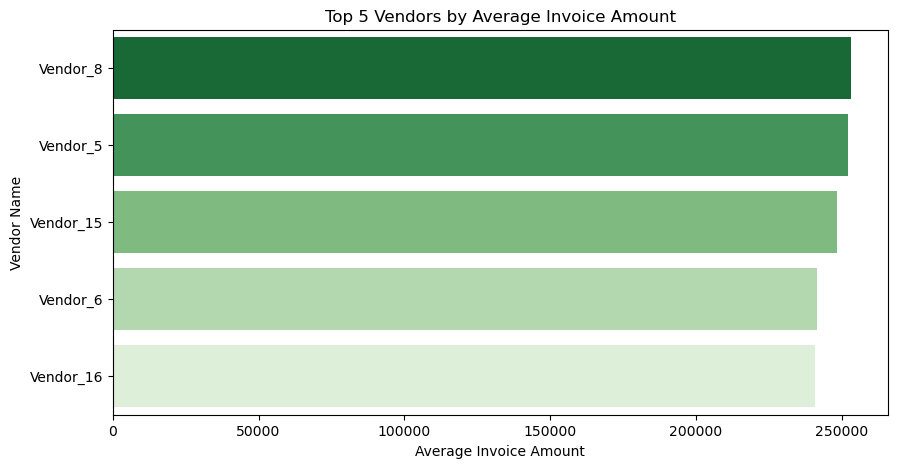

In [323]:
vendor_avg_amount = df.groupby("Vendor_Name")["Total_Amount_INR"].mean().sort_values(ascending=False).head(5)

plt.figure(figsize=(10,5))
sns.barplot(y=vendor_avg_amount.index, x=vendor_avg_amount.values, palette="Greens_r")
plt.xlabel("Average Invoice Amount")
plt.ylabel("Vendor Name")
plt.title("Top 5 Vendors by Average Invoice Amount")
plt.show()

/var/folders/b5/7xxf201d4dlgs0txsxw00m8w0000gn/T/ipykernel_14998/2105637539.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=vendor_pending_ratio.index, x=vendor_pending_ratio.values, palette="Reds_r")


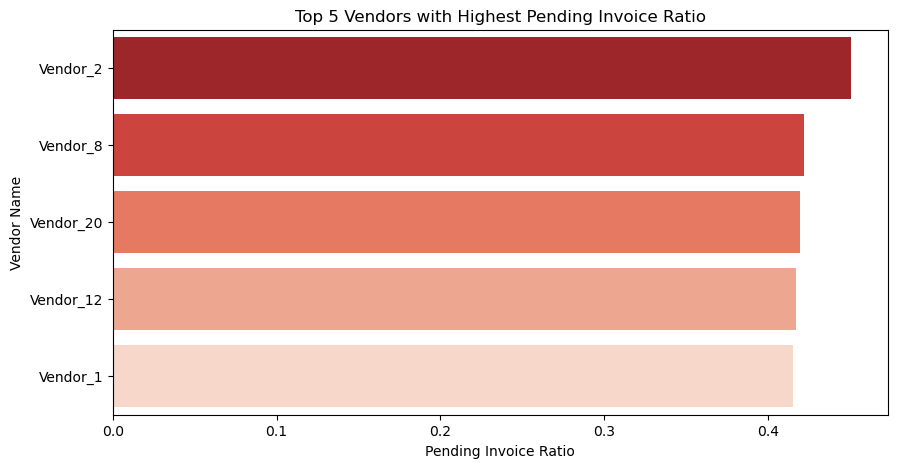

In [325]:
vendor_pending_ratio = df.groupby("Vendor_Name")["Status"].apply(lambda x: (x == "Pending").mean()).sort_values(ascending=False).head(5)

plt.figure(figsize=(10,5))
sns.barplot(y=vendor_pending_ratio.index, x=vendor_pending_ratio.values, palette="Reds_r")
plt.xlabel("Pending Invoice Ratio")
plt.ylabel("Vendor Name")
plt.title("Top 5 Vendors with Highest Pending Invoice Ratio")
plt.show()

Invoice Amount Analysis

Distribution of Invoice Amounts

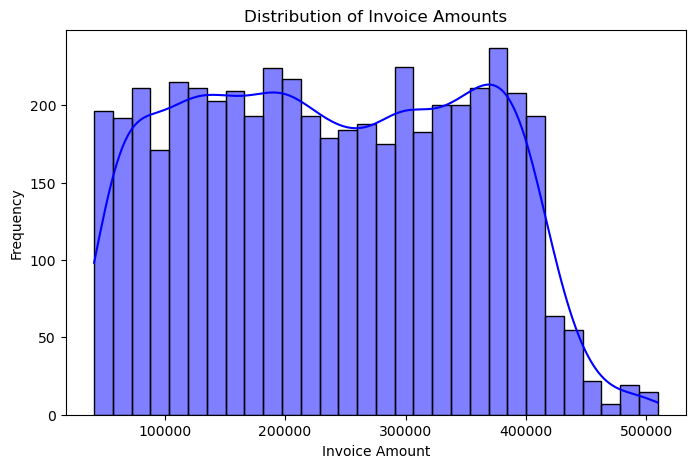

In [328]:
plt.figure(figsize=(8,5))
sns.histplot(df["Total_Amount_INR"], bins=30, kde=True, color="blue")
plt.xlabel("Invoice Amount")
plt.ylabel("Frequency")
plt.title("Distribution of Invoice Amounts")
plt.show()

Boxplot of Invoice Amounts (Detect Outliers)

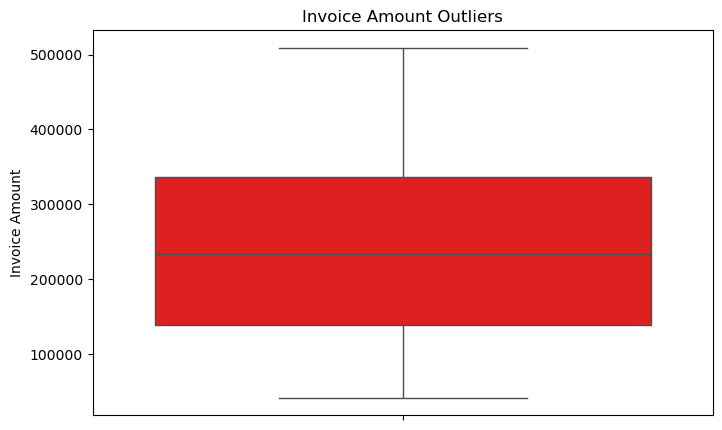

In [331]:
plt.figure(figsize=(8,5))
sns.boxplot(y=df["Total_Amount_INR"], color="red")
plt.ylabel("Invoice Amount")
plt.title("Invoice Amount Outliers")
plt.show()

feature engineering

In [334]:

# Encode target variable (1 = Paid, 0 = Pending)
df["Status"] = df["Status"].map({"Paid": 1, "Pending": 0})

df["Vendor_Frequency"] = df.groupby("Vendor_ID")["Invoice_ID"].transform("count")
df["Avg_Invoice_Amount"] = df.groupby("Vendor_ID")["Total_Amount_INR"].transform("mean")
df["Total_Invoice_Amount"] = df.groupby("Vendor_ID")["Total_Amount_INR"].transform("sum")
df["Pending_Ratio"] = df.groupby("Vendor_ID")["Status"].transform(lambda x: 1 - x.mean())
df["Invoice_Age"] = (pd.to_datetime("today") - df["Invoice_Date"]).dt.days


In [336]:
df.head()

,Invoice_ID,Vendor_ID,Invoice_Date,Status,Total_Amount_INR,Vendor_Name,Country,Category,Vendor_Frequency,Avg_Invoice_Amount,Total_Invoice_Amount,Pending_Ratio,Invoice_Age
0,INV-00001,VEND-019,2023-01-01,1,76680.450,Vendor_19,UK,IT Services,248,233740.768831,5.796771e+07,0.370968,793
1,INV-00002,VEND-008,2023-01-02,1,51248.175,Vendor_8,Canada,Office Equipment,263,253090.664449,6.656284e+07,0.422053,792
2,INV-00003,VEND-016,2023-01-03,1,278464.725,Vendor_16,UK,Consulting,247,240931.285891,5.951003e+07,0.356275,791
3,INV-00004,VEND-002,2023-01-04,1,427179.060,Vendor_2,USA,Consulting,233,229520.775064,5.347834e+07,0.450644,790
4,INV-00005,VEND-004,2023-01-05,0,357428.400,Vendor_4,UK,Stationery,250,229503.954960,5.737599e+07,0.320000,789


In [338]:
df.isna().sum()

Invoice_ID              0
Vendor_ID               0
Invoice_Date            0
Status                  0
Total_Amount_INR        0
Vendor_Name             0
Country                 0
Category                0
Vendor_Frequency        0
Avg_Invoice_Amount      0
Total_Invoice_Amount    0
Pending_Ratio           0
Invoice_Age             0
dtype: int64

Correlation Analysis
We check how different numerical features are related.



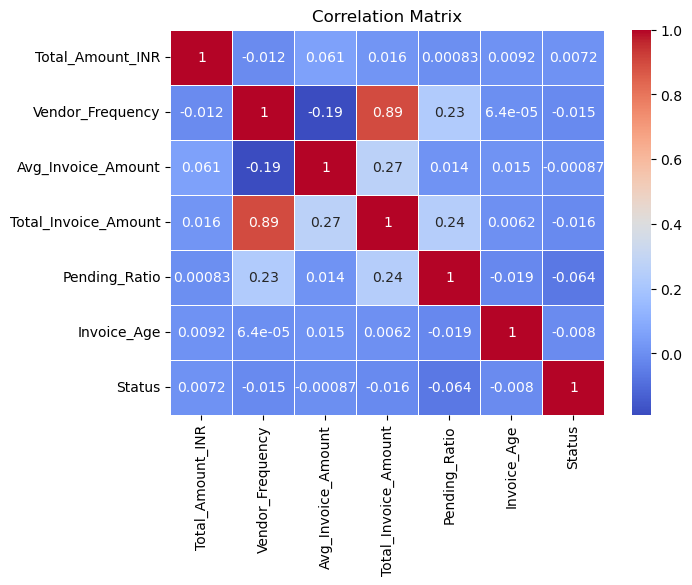

In [341]:

# Select numerical columns
corr_features = ["Total_Amount_INR", "Vendor_Frequency","Avg_Invoice_Amount","Total_Invoice_Amount","Pending_Ratio","Invoice_Age", "Status"]

# Compute correlation matrix
corr_matrix = df[corr_features].corr()

# Heatmap
plt.figure(figsize=(7,5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [343]:

# Select final features
features = ["Total_Amount_INR","Vendor_Frequency", "Avg_Invoice_Amount",
            "Total_Invoice_Amount", "Pending_Ratio", "Invoice_Age"]
X = df[features]  
y = df["Status"]  

# Handle missing values
X.fillna(X.median(), inplace=True)

# Split data into train & test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/var/folders/b5/7xxf201d4dlgs0txsxw00m8w0000gn/T/ipykernel_14998/2049468501.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)


In [345]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Train Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

# Train XGBoost
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:55:40] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📌 Random Forest Model Performance:
Accuracy: 0.523
              precision    recall  f1-score   support

           0       0.35      0.28      0.31       385
           1       0.60      0.67      0.64       615

    accuracy                           0.52      1000
   macro avg       0.48      0.48      0.47      1000
weighted avg       0.50      0.52      0.51      1000



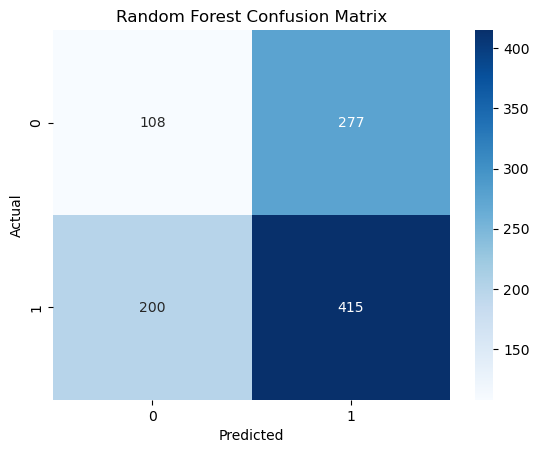


📌 Gradient Boosting Model Performance:
Accuracy: 0.611
              precision    recall  f1-score   support

           0       0.45      0.05      0.09       385
           1       0.62      0.96      0.75       615

    accuracy                           0.61      1000
   macro avg       0.54      0.51      0.42      1000
weighted avg       0.55      0.61      0.50      1000



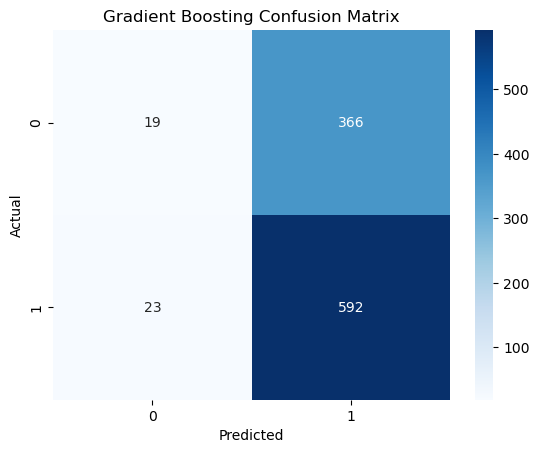


📌 XGBoost Model Performance:
Accuracy: 0.518
              precision    recall  f1-score   support

           0       0.32      0.23      0.27       385
           1       0.59      0.70      0.64       615

    accuracy                           0.52      1000
   macro avg       0.46      0.46      0.45      1000
weighted avg       0.49      0.52      0.50      1000



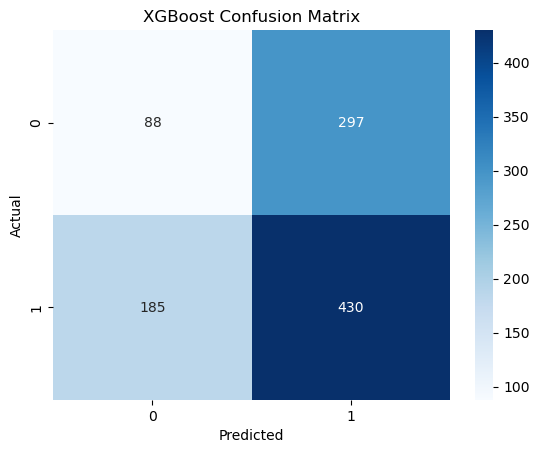

In [267]:
# Evaluate each model
def evaluate_model(model_name, y_test, y_pred):
    print(f"\n📌 {model_name} Model Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

# Evaluate models
evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("Gradient Boosting", y_test, gb_pred)
evaluate_model("XGBoost", y_test, xgb_pred)


📌 Logistic Regression Model Performance:
Accuracy: 0.615
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       385
           1       0.61      1.00      0.76       615

    accuracy                           0.61      1000
   macro avg       0.31      0.50      0.38      1000
weighted avg       0.38      0.61      0.47      1000



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


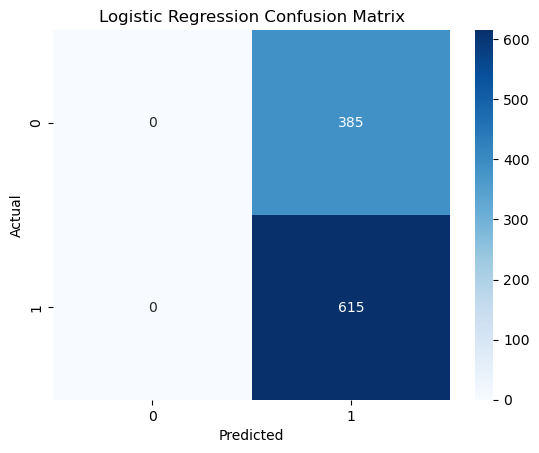

In [347]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)

evaluate_model("Logistic Regression", y_test, log_pred)


📌 Support Vector Machine (SVM) Model Performance:
Accuracy: 0.615
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       385
           1       0.61      1.00      0.76       615

    accuracy                           0.61      1000
   macro avg       0.31      0.50      0.38      1000
weighted avg       0.38      0.61      0.47      1000



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


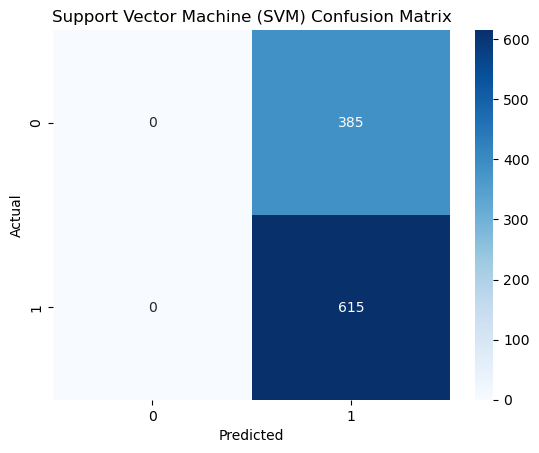

In [349]:
from sklearn.svm import SVC

svm_model = SVC(kernel="rbf", probability=True)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

evaluate_model("Support Vector Machine (SVM)", y_test, svm_pred)


📌 K-Nearest Neighbors (KNN) Model Performance:
Accuracy: 0.522
              precision    recall  f1-score   support

           0       0.35      0.29      0.32       385
           1       0.60      0.67      0.63       615

    accuracy                           0.52      1000
   macro avg       0.48      0.48      0.47      1000
weighted avg       0.50      0.52      0.51      1000



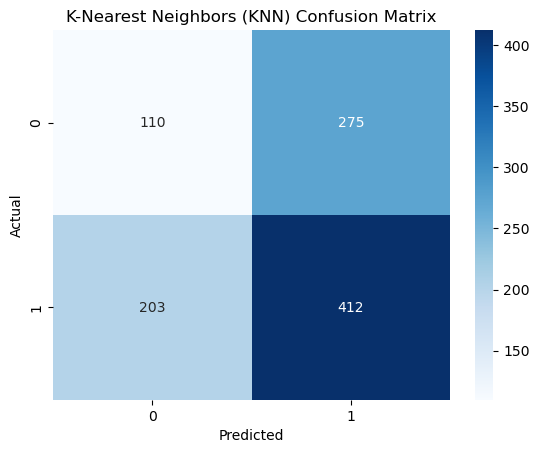

In [351]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

evaluate_model("K-Nearest Neighbors (KNN)", y_test, knn_pred)

/var/folders/b5/7xxf201d4dlgs0txsxw00m8w0000gn/T/ipykernel_14998/2881789026.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="Blues_r")


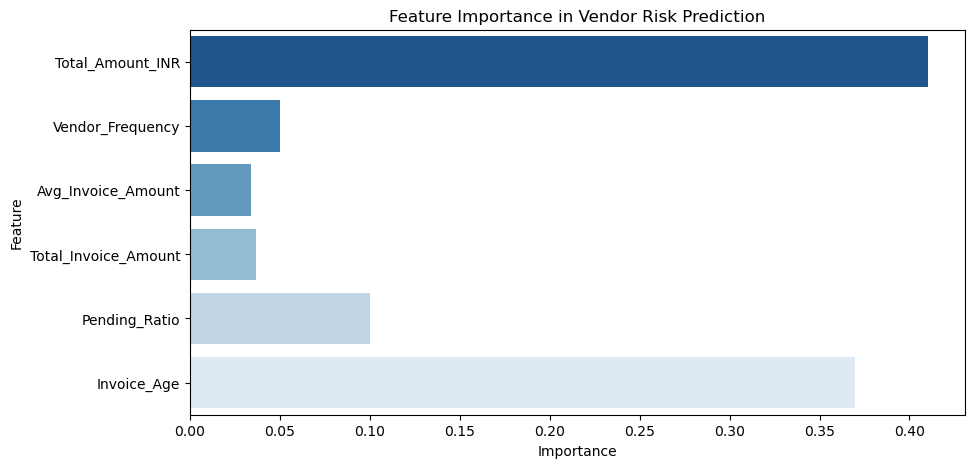

In [353]:
# Get feature importances from Random Forest
importances = gb_model.feature_importances_
feature_names = X.columns

# Plot feature importance
plt.figure(figsize=(10,5))
sns.barplot(x=importances, y=feature_names, palette="Blues_r")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Vendor Risk Prediction")
plt.show()

Save the Best Model


In [356]:
import joblib

# Save the best model (replace `rf_model` with your best model)
joblib.dump(gb_model, "vendor_risk_model.pkl")

print("Model saved successfully!")

Model saved successfully!


Deploy as an API using FastAPI

In [363]:
from fastapi import FastAPI
import joblib
import pandas as pd

# Load the saved model
model = joblib.load("vendor_risk_model.pkl")

# Initialize FastAPI app
app = FastAPI()

@app.get("/")
def home():
    return {"message": "Vendor Risk Prediction API is running!"}

@app.post("/predict/")
def predict_risk(total_amount_INR: float, currency: int, vendor_frequency: int,
                 avg_invoice_amount: float, total_invoice_amount: float,
                 pending_ratio: float, invoice_age: int):
    
    # Prepare input data
    input_data = pd.DataFrame({
        "Total_Amount_INR": [total_amount_INR],
        "Vendor_Frequency": [vendor_frequency],
        "Avg_Invoice_Amount": [avg_invoice_amount],
        "Total_Invoice_Amount": [total_invoice_amount],
        "Pending_Ratio": [pending_ratio],
        "Invoice_Age": [invoice_age]
    })

    # Make prediction
    prediction = model.predict(input_data)[0]

    # Return result
    return {"Predicted Status": "Paid" if prediction == 1 else "Pending"}
